In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os
import tqdm
import glob
import tensorflow

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import gray2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import DenseNet121 

from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
import keras.backend as K

from typing import Optional

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,

        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [7]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Colab Notebooks/MCI-CN/MCI-CN/train',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   subset = 'training',
                                                   batch_size = 32)

Found 858 images belonging to 2 classes.


In [8]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Colab Notebooks/MCI-CN/MCI-CN/train',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  subset = 'validation',
                                                  batch_size = 32)

Found 214 images belonging to 2 classes.


In [9]:
test_dataset = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Colab Notebooks/MCI-CN/MCI-CN/test',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 32)

Found 286 images belonging to 2 classes.


In [10]:
base_model = DenseNet121(input_shape=(224,224,3),
                   include_top=False,
                   weights="imagenet")

29084464/29084464 [==============================] - 0s 0us/step


In [11]:
for layer in base_model.layers:
    layer.trainable=False


In [12]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(Dense(1, activation='sigmoid'))

In [13]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [14]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5) 

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [15]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [16]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=METRICS)

In [17]:
history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 20,
                        verbose = 1,
                         callbacks=lr_scheduler)

Epoch 1/20
27/27 [==============================] - 606s 22s/step - loss: 0.4583 - accuracy: 0.7844 - precision: 0.8304 - recall: 0.7734 - auc: 0.8652 - f1_score: 0.8011 - val_loss: 4.4187 - val_accuracy: 0.6402 - val_precision: 0.6091 - val_recall: 1.0000 - val_auc: 0.6569 - val_f1_score: 0.7566 - lr: 0.0100
Epoch 2/20
27/27 [==============================] - 15s 568ms/step - loss: 0.3370 - accuracy: 0.8625 - precision: 0.9097 - recall: 0.8378 - auc: 0.9284 - f1_score: 0.8742 - val_loss: 0.8477 - val_accuracy: 0.8318 - val_precision: 0.9667 - val_recall: 0.7250 - val_auc: 0.8925 - val_f1_score: 0.8291 - lr: 0.0063
Epoch 3/20
27/27 [==============================] - 15s 561ms/step - loss: 0.2879 - accuracy: 0.8939 - precision: 0.9149 - recall: 0.8940 - auc: 0.9472 - f1_score: 0.9002 - val_loss: 0.7970 - val_accuracy: 0.8411 - val_precision: 0.9574 - val_recall: 0.7500 - val_auc: 0.8956 - val_f1_score: 0.8368 - lr: 0.0040
Epoch 4/20
27/27 [==============================] - 15s 560ms/ste

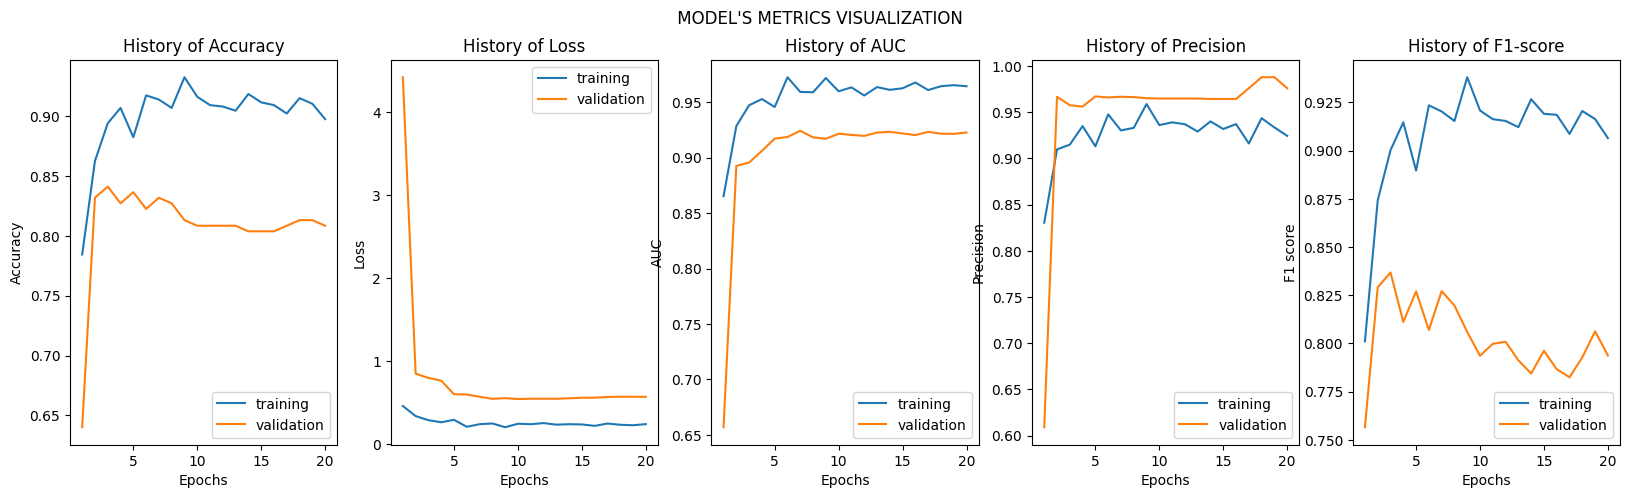

In [18]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):

    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [19]:
scores = model.evaluate(test_dataset)


9/9 [==============================] - 113s 14s/step - loss: 0.1497 - accuracy: 0.9406 - precision: 0.9569 - recall: 0.9024 - auc: 0.9902 - f1_score: 0.9254


In [20]:
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

Accuracy =  0.940559446811676
Precision =  0.9568965435028076
Recall =  0.9024389982223511
AUC =  0.9902489185333252
F1_score =  0.9254113435745239


1/1 [==============================] - 0s 51ms/step


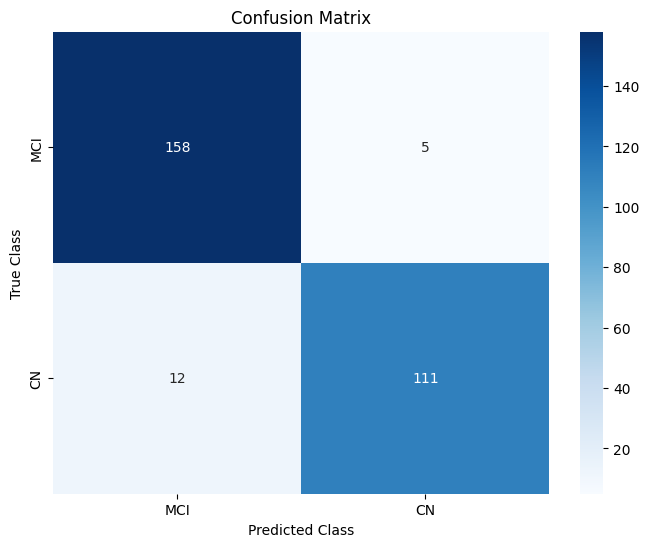

In [24]:

import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


test_dataset.batch_size = 32  


y_true = []  # True labels
y_pred = []  # Predicted labels

# Iterate over the test dataset
for batch, labels in test_dataset:
    # Predict using the model
    predictions = model.predict(batch)

    # Convert predictions to binary (0 or 1) based on a threshold
    predictions = (predictions > 0.5).astype(int).flatten()

    # Extend the y_true and y_pred lists
    y_true.extend(labels)
    y_pred.extend(predictions)

    # Break loop if the dataset is fully iterated
    if len(y_true) >= len(test_dataset.filenames):
        break

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sn.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=['MCI', 'CN'], yticklabels=['MCI', 'CN'])

plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()
